In [ ]:
!pip install --quiet kaggle


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d veeralakrishna/aggressive-driving-data

Dataset URL: https://www.kaggle.com/datasets/veeralakrishna/aggressive-driving-data
License(s): CC0-1.0
  0% 0.00/3.23M [00:00<?, ?B/s]
100% 3.23M/3.23M [00:00<00:00, 84.7MB/s]


In [ ]:
!unzip aggressive-driving-data
!rm aggressive-driving-data.zip

Archive:  aggressive-driving-data.zip
replace AttributeInformation.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: No


In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


In [ ]:
train_path = '/content/Train_Data/Train.csv'
trainVehicle = '/content/Train_Data/Train_Vehicletravellingdata.csv'
trainWeather = '/content/Train_Data/Train_WeatherData.csv'

In [ ]:
train = pd.read_csv(train_path)
train_Vehicle = pd.read_csv(trainVehicle)
train_Weather = pd.read_csv(trainWeather)

In [ ]:
len(train),len(train_Vehicle),len(train_Weather)

(12994, 162566, 162566)

In [ ]:
train.head()

,ID,V2,V5,V6,DrivingStyle
0,DR_24526,1265,10243,2,2
1,DR_30052,1680,30871,6,2
2,DR_40928,936,3224,4,2
3,DR_66033,1503,3315,4,2
4,DR_45266,929,3022,4,2


In [ ]:
# merge the data
df = train.merge(train_Vehicle,on='ID',how='left')
df = df.merge(train_Weather,on='ID',how='left')

In [ ]:
# V1_x (found in the train_Vehicle dataset) refers to the date and time when the data was collected during the trip.
# V1_y is the same but refers to the train_Weather dataset.
# During the merge a different suffix was given to differentiate them
df.head()

,ID,V2,V5,V6,DrivingStyle,V1_x,V3,V4,V7,V8,...,V11,V18,V1_y,V12,V13,V14,V15,V16,V17,V19
0,DR_24526,1265,10243,2,2,2012-03-21 09:14:55,1,81,57227,87,...,94.0,Dry,2012-03-21 09:14:55,7.0,clear,NaN,95.0,146.0,1.0,daylight
1,DR_24526,1265,10243,2,2,2012-03-21 09:14:55,1,81,57227,87,...,94.0,Dry,2012-03-21 09:15:07,7.0,clear,NaN,95.0,124.0,0.0,daylight
2,DR_24526,1265,10243,2,2,2012-03-21 09:14:55,1,81,57227,87,...,94.0,Dry,2012-03-21 09:15:12,7.0,clear,NaN,95.0,124.0,0.0,daylight
3,DR_24526,1265,10243,2,2,2012-03-21 09:14:55,1,81,57227,87,...,94.0,Dry,2012-03-21 09:15:48,7.0,clear,NaN,95.0,124.0,0.0,daylight
4,DR_24526,1265,10243,2,2,2012-03-21 09:14:55,1,81,57227,87,...,94.0,Dry,2012-03-21 09:15:54,7.0,clear,NaN,95.0,124.0,0.0,daylight


In [ ]:
# remove date features
df.drop(['V1_x','V1_y'],axis=1,inplace=True)

In [ ]:
# check how many NaN values are present and how many duplicates
def checking_function(df):
    if df.isna().sum().any():
        print('Nan values are present')
    else:
        print('No Nan values')

    if df.duplicated().any():
        print('Duplicates are present')
    else:
        print('No duplicates')


In [ ]:
checking_function(df)

Nan values are present
Duplicates are present


In [ ]:
# check the relative frequency of NaN values
df.isna().sum()/len(df)

ID              0.000000
V2              0.000000
V5              0.000000
V6              0.000000
DrivingStyle    0.000000
V3              0.000000
V4              0.000000
V7              0.000000
V8              0.000000
V9              0.000000
V10             0.000000
V11             0.019861
V18             0.000000
V12             0.011200
V13             0.000000
V14             0.934428
V15             0.011507
V16             0.011566
V17             0.013787
V19             0.000000
dtype: float64

In [ ]:
# V14 feature according to the explanation of features on kaggle refer to precipitation intensity
# We have over 90% of missing values!, with a so high percentage, should be better to remove the feature
df['V14'].value_counts()

# remove the feature from the dataset
df.drop('V14',axis=1,inplace=True)

In [ ]:
# check how many duplicates are present
print(df.duplicated().sum())

# There's a lot of duplicates who inflate the dimension of the dataset after removing Date features
df.drop_duplicates(inplace=True)

3359471


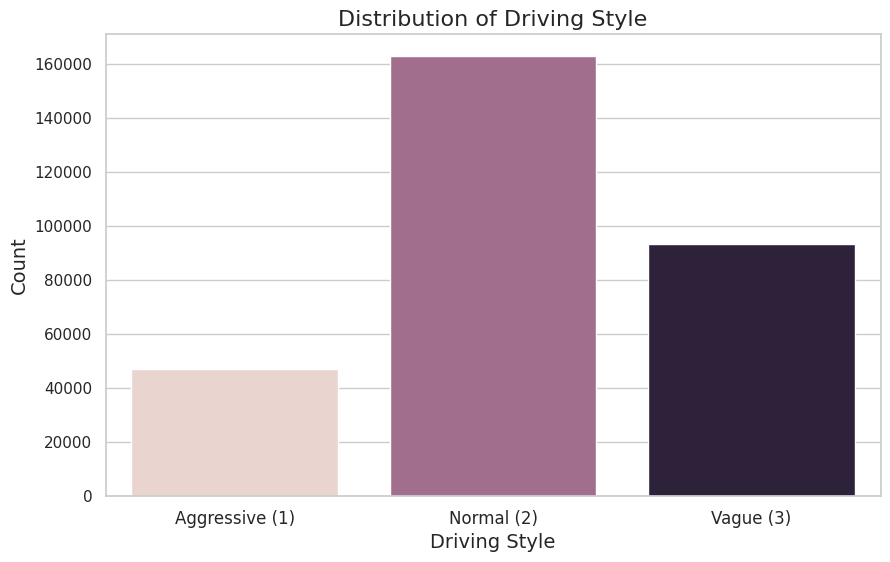

In [ ]:
# Ensure we have the latest Seaborn version
sns.set(style="whitegrid")

# Column names
column_names = ['Aggressive (1)','Normal (2)','Vague (3)']

# Create the count plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='DrivingStyle', data=df,hue='DrivingStyle',legend=False)

# Set the labels and title
plt.xticks(range(len(column_names)), column_names, fontsize=12)
plt.xlabel('Driving Style', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Driving Style', fontsize=16)
# Display the plot
plt.show()


## Data Preparation Report - Sprint 1

### Objective
Prepare and clean the dataset to ensure high-quality data for further analysis and modeling.

### Task Summary
1. **Dataset Joining**
2. **Handling Missing Data**
3. **Imputation Strategy**
4. **Removing Duplicates and NaN Values**

### 1. Dataset Joining
- **Action**: Merged three datasets.
- **Join Key**: Used `DriverID` for the join.
- **Status**: Completed.

### 2. Handling Missing Data
- **Variable Removal**:
  - Removed variable `V14` due to over 90% missing data.
  - Removed variables `V1_x` (from dataset `train_Vehicle`) and `V1_y` (from dataset `train_Weather`) as they represented the timestamp of data collection.
- **Remaining Missing Values**: Other variables have ~1% missing values.
  - **Plan**: Impute missing values in the preprocessing phase.
- **Status**: In progress.

### 3. Imputation Strategy
- **Current Status**: To be defined in preprocessing.
- **Next Steps**:
  - Research and select appropriate imputation methods.
  - Implement and validate the imputation method.

### 4. Removing Duplicates and NaN Values
- **Action**: Identified and removed duplicate observations.
- **Next Steps**:
  - Check for remaining NaN values.
  - Ensure dataset integrity for analysis and modeling.

### Impediments
- **None identified at this stage.**

### Next Sprint Goals
1. Check correlation/Multicollinearity.
2. Check correlation between categorical variables using Chi-Square.

---

In [ ]:
# plot the correlation between numerical features
num_features = df.select_dtypes(include=['int64', 'float64', 'datetime64[ns]'])
num_features = num_features.drop('DrivingStyle', axis=1)

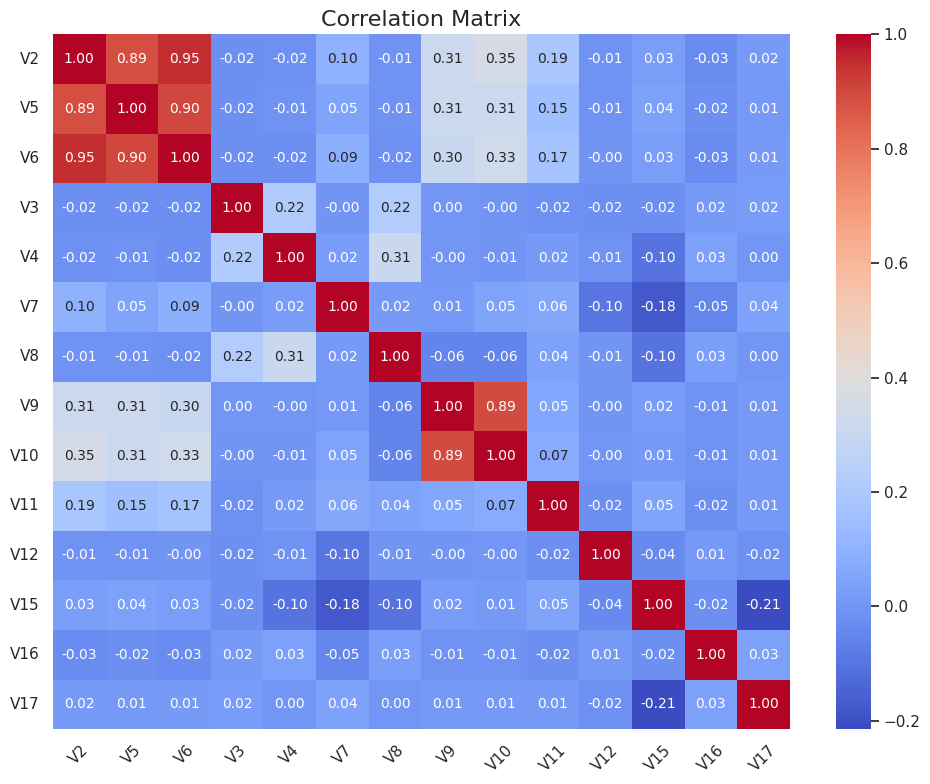

In [ ]:
# Clusters of high correlation are present in the correlation matrix,
# indicating potential multicollinearity between certain features.
corr_matrix = num_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})

# Add labels and title
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
cat_features = df.select_dtypes(include=['object'])
cat_features = cat_features.drop('ID', axis=1)

In [ ]:
# Extracting column names
column_names = cat_features.columns
# Assiging column names to row indexs
chisqmatrix=pd.DataFrame(cat_features,columns=column_names,index=column_names)

In [ ]:
for icol in column_names:  # Loop over each column (categorical variable) in the DataFrame.
    for jcol in column_names:  # Nested loop to compare with each other column.

        # Create a contingency table for the two categorical columns icol and jcol.
        mycrosstab = pd.crosstab(cat_features[icol], cat_features[jcol])

        # Perform a chi-square test of independence on the contingency table.
        chi2, _, _, _ = stats.chi2_contingency(mycrosstab)

        # Calculate Cramér's V for the association between icol and jcol.
        n = mycrosstab.values.sum()  # Calculate the total number of observations.
        V = np.sqrt(chi2 / (n * (min(mycrosstab.shape) - 1)))  # Compute Cramér's V.
        V = round(V, 3)  # Round the value to three decimal places for readability.

        # Store the calculated Cramér's V value in the chisqmatrix DataFrame.
        chisqmatrix.loc[icol, jcol] = V

# Make values inside chisq matrix float
chisqmatrix = chisqmatrix.astype(float)

<Axes: >

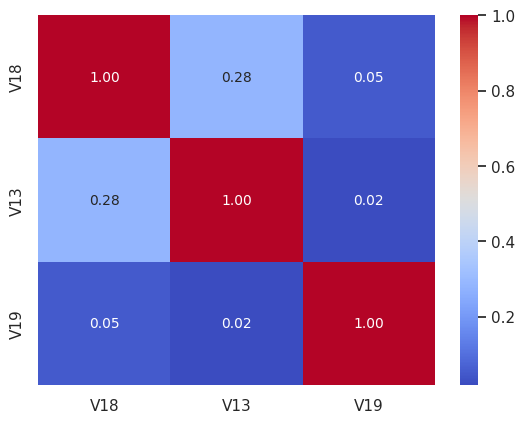

In [ ]:
# We have only one weak positive correlation between feature V13 and feature V18
sns.heatmap(chisqmatrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})

## Chi-Square and Correlation Analysis Report

### Objective
Conduct Chi-Square tests and correlation analysis to understand relationships between variables in the dataset.

### Analysis Summary

#### Chi-Square Test Results

- **V13 (Weather detail - precipitation type)** and **V18 (Condition of the road relative to weather)**:
  - **Result**: A weak positive correlation was observed (Chi-Square test).
  - **Explanation**: This correlation is logical as different weather types (V13) can influence road conditions (V18), such as Dry, Wet, or Snow covered.

#### Correlation Analysis Results

- **High Correlation Clusters**:
  - Identified clusters:
    - **V2**, **V5**, and **V6**: Length, weight, and number of axles.
    - **V9** and **V10**: Weight and length of the preceding vehicle.
  - **Insights**: These correlations provide insights into vehicle characteristics and potential factors influencing vehicle design and performance.

### Implications
Understanding these relationships aids in:
- Feature selection for predictive modeling.

### Next Steps

1. **Visualize the data**:
   - Visualize the distribution of the data and get insight about outliers.

---


In [ ]:
# analysis of continuous variables
ContVar = df[['V2','V4','V5','V8','V9','V10','V11']]

In [ ]:
ContVar.loc[:,'V2_m'] = ContVar['V2'] / 100.0  # Convert cm to meters using .loc for assignment
ContVar.loc[:,'V10_m'] = ContVar['V10'] / 100.0  # Convert cm to meters using .loc for assignment

<ipython-input-25-f3125bb9df50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ContVar.loc[:,'V2_m'] = ContVar['V2'] / 100.0  # Convert cm to meters using .loc for assignment
<ipython-input-25-f3125bb9df50>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ContVar.loc[:,'V10_m'] = ContVar['V10'] / 100.0  # Convert cm to meters using .loc for assignment


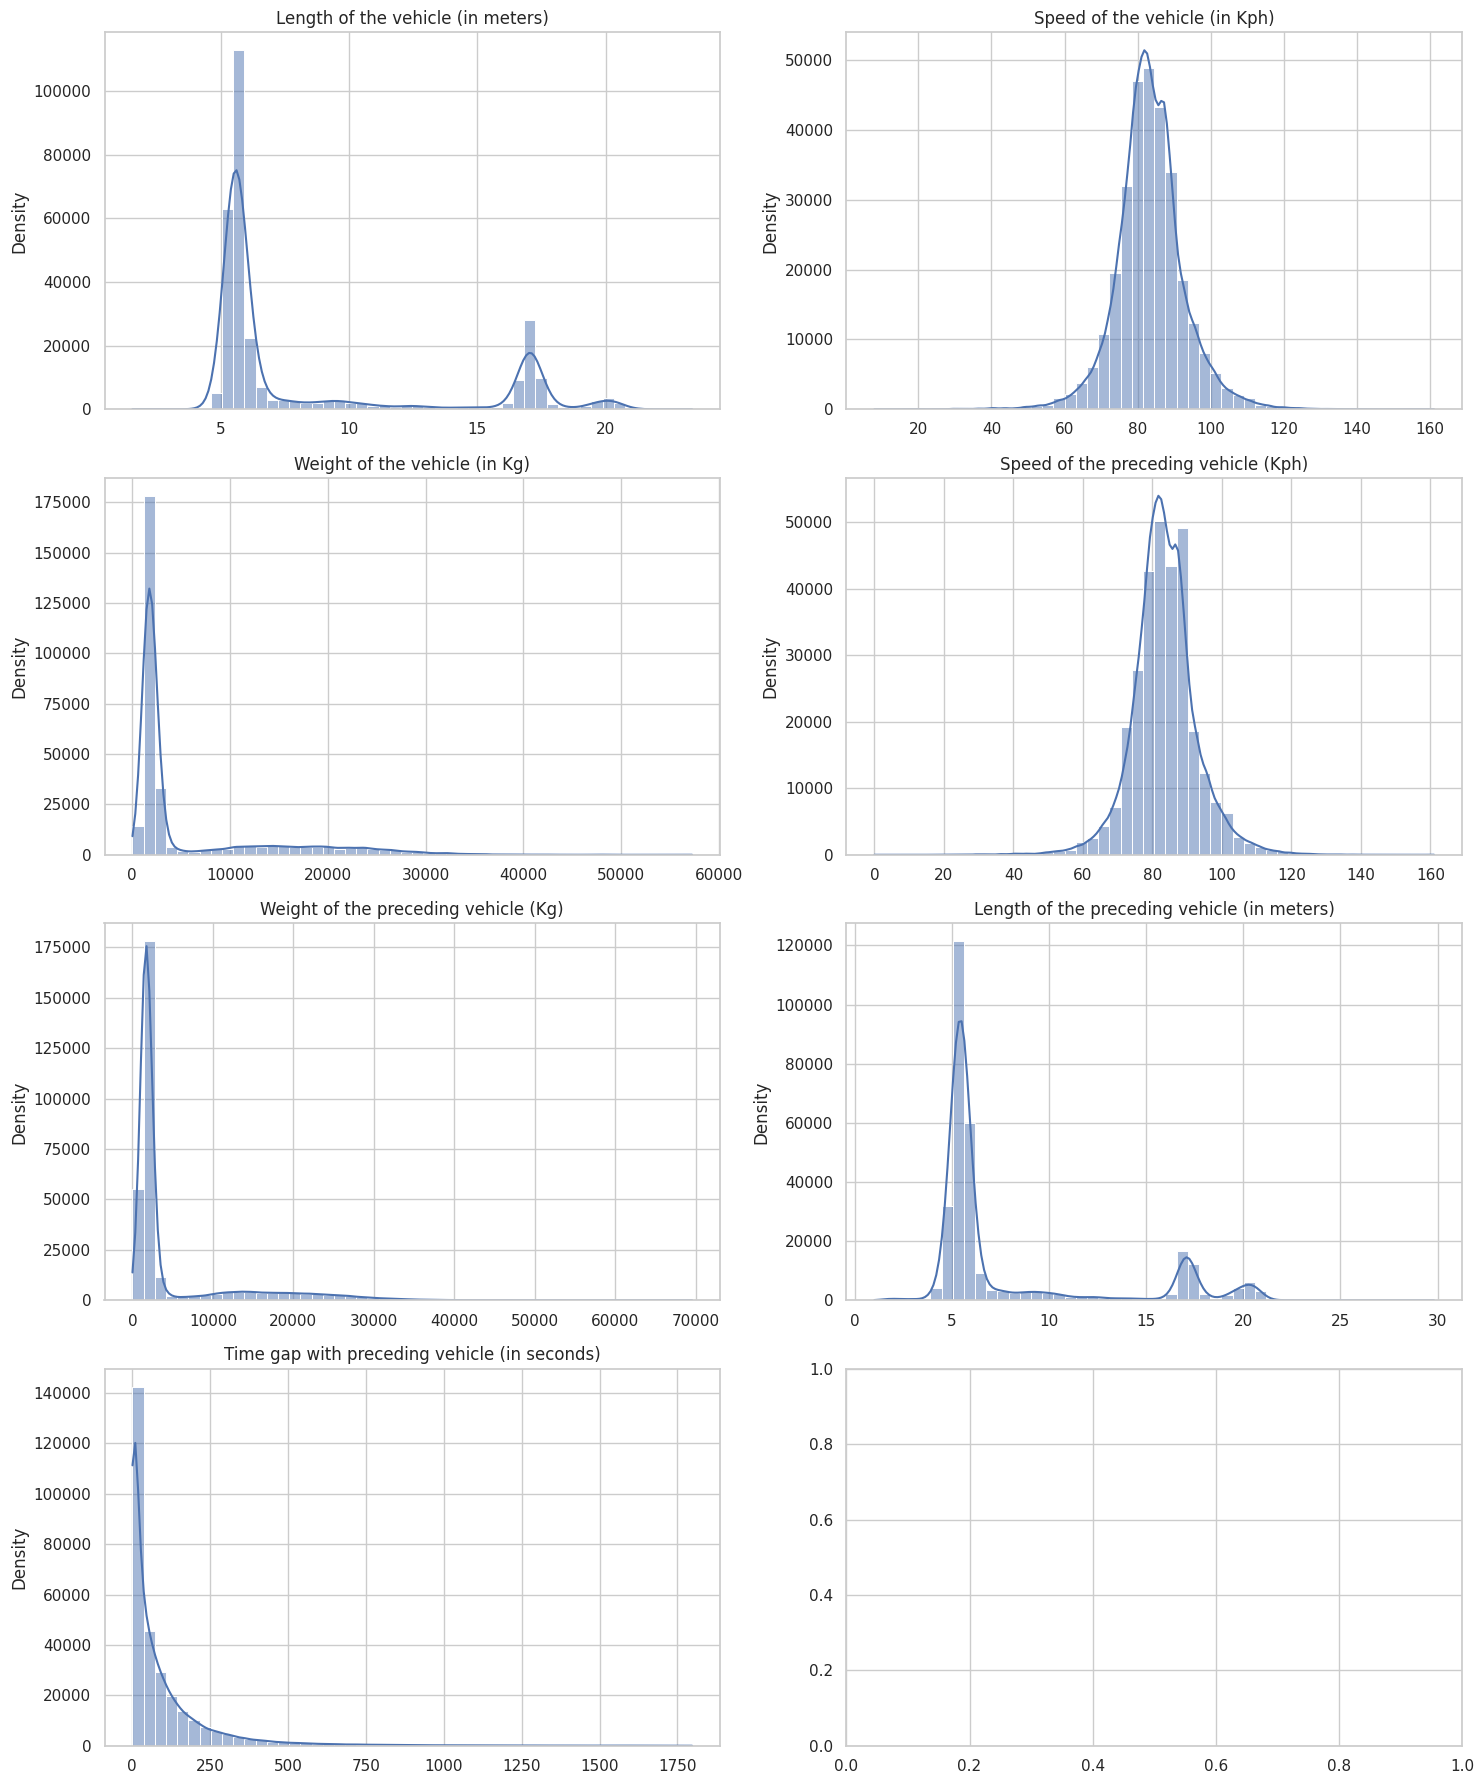

In [ ]:
# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 18))
sns.set(style="whitegrid")

# List of variables to plot
variables = ['V2_m', 'V4', 'V5', 'V8', 'V9', 'V10_m', 'V11']
titles = ['Length of the vehicle (in meters)',
          'Speed of the vehicle (in Kph)',
          'Weight of the vehicle (in Kg)',
          'Speed of the preceding vehicle (Kph)',
          'Weight of the preceding vehicle (Kg)',
          'Length of the preceding vehicle (in meters)',
          'Time gap with preceding vehicle (in seconds)']

# Plotting using Seaborn
for ax, var, title in zip(axs.flatten(), variables, titles):
    sns.histplot(data=ContVar, x=var, kde=True, bins=50, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()

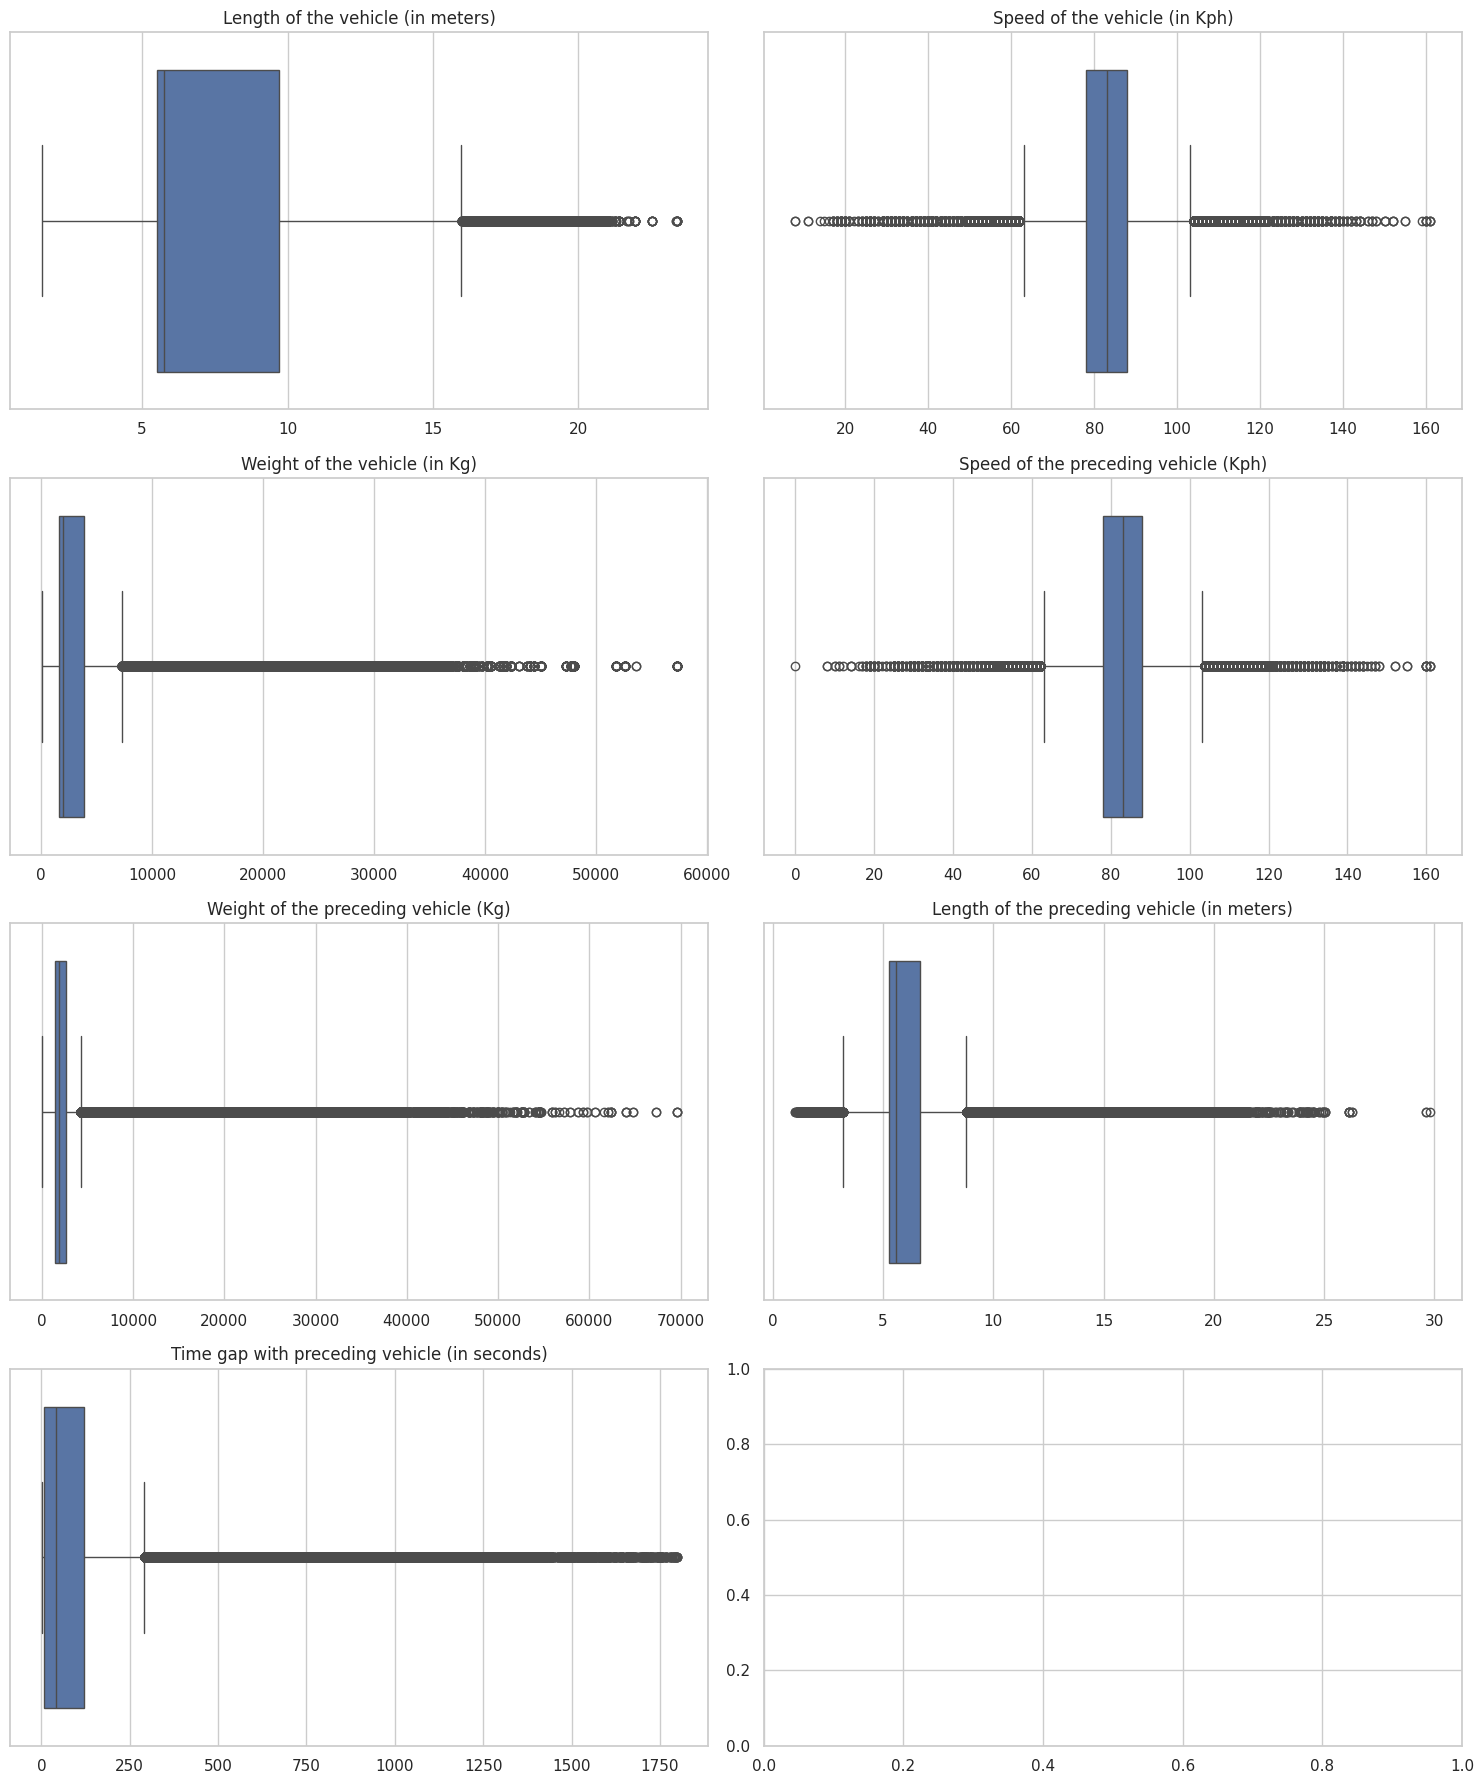

In [ ]:
# plot boxplot
fig, axs = plt.subplots(4, 2, figsize=(15, 18))
sns.set(style="whitegrid")

# List of variables to plot
variables = ['V2_m', 'V4', 'V5', 'V8', 'V9', 'V10_m', 'V11']
titles = ['Length of the vehicle (in meters)',
          'Speed of the vehicle (in Kph)',
          'Weight of the vehicle (in Kg)',
          'Speed of the preceding vehicle (Kph)',
          'Weight of the preceding vehicle (Kg)',
          'Length of the preceding vehicle (in meters)',
          'Time gap with preceding vehicle (in seconds)']

       # Plotting
for i in range(len(variables)):
    variable = variables[i]
    title = titles[i]
    sns.boxplot(data=ContVar, x=variable, ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(title)
    axs[i // 2, i % 2].set_xlabel('')
    axs[i // 2, i % 2].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
CatVar = df[['V3','V6','V12','V13','V15','V16','V17','V18','V19']]

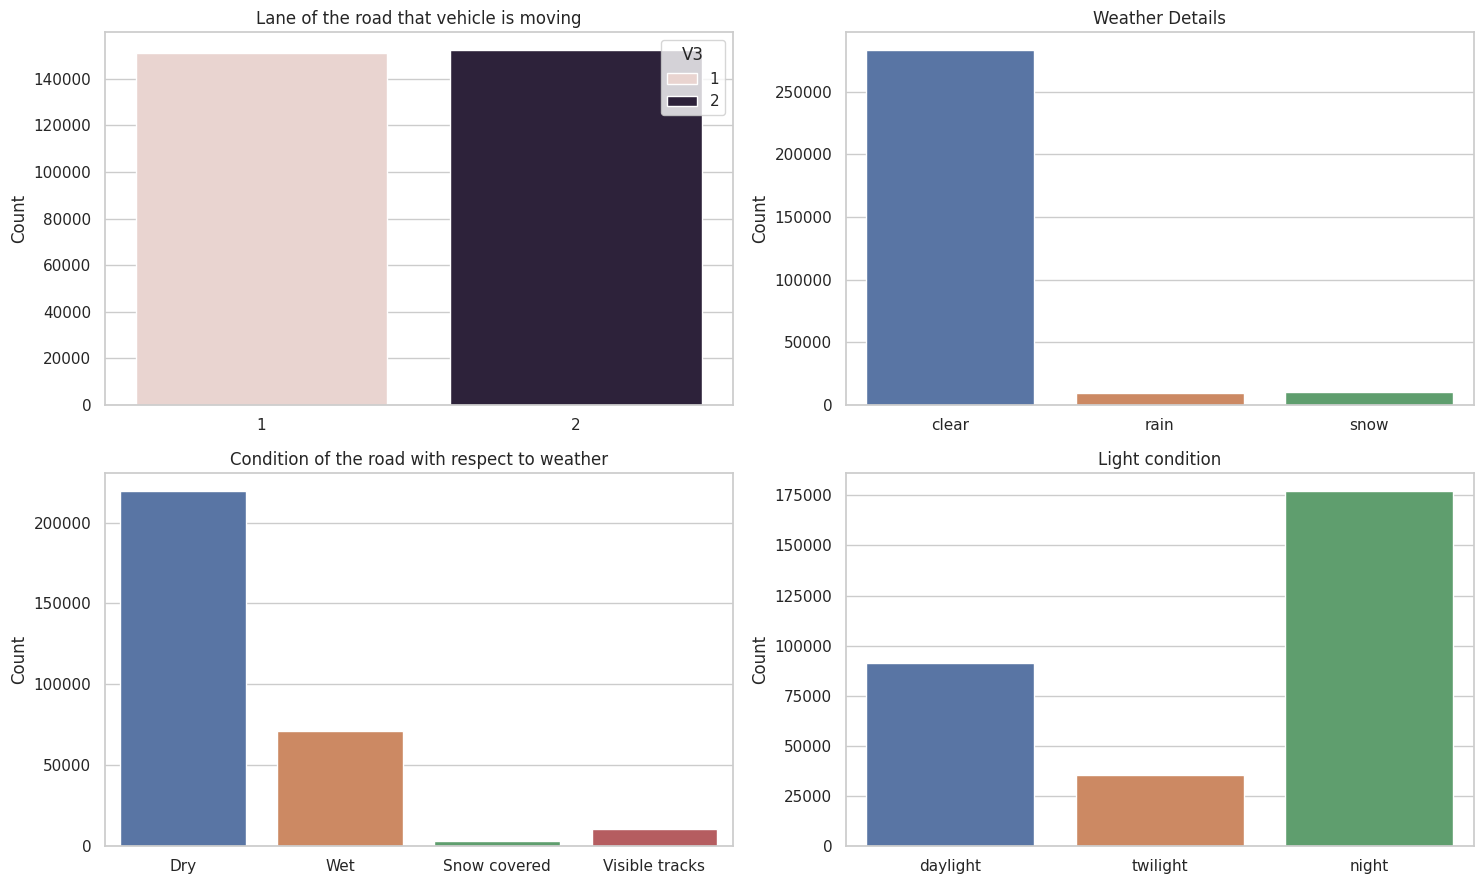

In [ ]:
# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 9))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# List of categorical variable names and titles
cat_vars = ['V3', 'V13', 'V18', 'V19']
titles = [
    'Lane of the road that vehicle is moving',
    'Weather Details',
    'Condition of the road with respect to weather',
    'Light condition'
]

# Plot each categorical variable in a subplot
for i, var in enumerate(cat_vars):
    sns.countplot(data=CatVar, x=var, ax=axs[i], hue=var)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

### Sprint 2 Report - Data Exploration and Insights

#### Objective
Analyze and interpret the dataset to identify key patterns and trends that could impact the classification of driving styles.

#### Task Summary
1. **Vehicle Length Analysis**
2. **Speed Distribution Analysis**
3. **Lane Occupation Analysis**
4. **Weather Condition Analysis**
5. **Light Condition Analysis**
6. **Outlier Detection and Handling**

#### 1. Vehicle Length Analysis
- **Observation**: The majority of vehicles in the dataset are cars.
- **Detail**: The distribution of vehicle length peaks around 5 meters, which is typical for cars.
- **Additional Insight**: There are also some heavy and long vehicles, likely trucks and tractor-trailers (camion and autotreni).

#### 2. Speed Distribution Analysis
- **Observation**: The speed distribution approximates a normal distribution.
- **Detail**: The mean speed is around 80 Kph.
- **Impact**: This information will be useful in understanding typical driving patterns and anomalies.

#### 3. Lane Occupation Analysis
- **Observation**: Vehicles occupy the first and second lanes almost equally.
- **Detail**: This suggests balanced lane usage without a significant preference for one lane over the other.
- **Impact**: This insight helps in understanding the driving behavior concerning lane usage.

#### 4. Weather Condition Analysis
- **Observation**: Clear weather with a dry road is the dominant condition.
- **Detail**: Snow conditions are minimally represented, followed by rain conditions.
- **Impact**: The weather conditions will need to be factored into the model, especially for edge cases like snow and rain.

#### 5. Light Condition Analysis
- **Observation**: Night is the most prominent light condition.
- **Detail**: This suggests a significant amount of driving occurs at night, which may affect driving style and safety.
- **Impact**: Light conditions will be an important feature to consider in the classification model.

#### 6. Outlier Detection and Handling
- **Observation**: Several outliers were identified in the dataset.
- **Detail**: Outliers were primarily found in the speed distribution and vehicle length categories.
- **Impact**: Addressing outliers is crucial for maintaining model accuracy and reliability. Further investigation into these outliers will be necessary to determine if they are errors or legitimate data points that require special handling.

### Impediments
- **None identified at this stage.**

### Next Sprint Goals
1. **Feature Engineering**:
   - Create new features from the existing data (using physics).
   - Discretize continuous features (like vehicle length).
2. **Outlier Investigation**:
   - Investigate outliers to determine their impact on model training and performance.
   - Implement strategies for handling outliers appropriately.


In [ ]:
# create a copy of the dataset to work on
data = df.copy()

In [ ]:
bins = [0, 450, 500, 600, 1200,float('inf')]
labels = ['Small Car', 'Medium Car', 'Large Car', 'Truck', 'Long Truck',]

# Discretize the vehicle length
data['vehicle_category'] = pd.cut(data['V2'], bins=bins, labels=labels, right=False)

# discretize in the same way the lenght of the preceding vehicle
data['prec_vehicle_category'] = pd.cut(data['V10'], bins=bins, labels=labels, right=False)

In [ ]:
data['prec_vehicle_category'].value_counts()

prec_vehicle_category
Large Car     178496
Long Truck     53459
Truck          40637
Medium Car     24740
Small Car       6203
Name: count, dtype: int64

In [ ]:
# remove V2 and V10
data.drop(['V2','V10'],inplace = True,axis=1)

In [ ]:
# transform the weight of the vehicle and the preceding vehicle
data.loc[:,'V5'] = data['V5'] / 1000.0  # Convert kg to tons using .loc for assignment
data.loc[:,'V9'] = data['V9'] / 1000.0  # Convert kg to tons using .loc for assignment


In [ ]:
# change the name for cols V5 and V9
data.rename(columns={'V5':'vehicle_weight','V9':'prec_vehicle_weight','V4':'vehicle_speed','V8':'prec_vehicle_speed'},inplace=True)

In [ ]:
data.head()

,ID,vehicle_weight,V6,DrivingStyle,V3,vehicle_speed,V7,prec_vehicle_speed,prec_vehicle_weight,V11,V18,V12,V13,V15,V16,V17,V19,vehicle_category,prec_vehicle_category
0,DR_24526,10.243,2,2,1,81,57227,87,16.986,94.0,Dry,7.0,clear,95.0,146.0,1.0,daylight,Long Truck,Truck
1,DR_24526,10.243,2,2,1,81,57227,87,16.986,94.0,Dry,7.0,clear,95.0,124.0,0.0,daylight,Long Truck,Truck
19,DR_24526,10.243,2,2,1,88,57229,81,1.708,11.0,Dry,7.0,clear,95.0,146.0,1.0,daylight,Long Truck,Large Car
20,DR_24526,10.243,2,2,1,88,57229,81,1.708,11.0,Dry,7.0,clear,95.0,124.0,0.0,daylight,Long Truck,Large Car
38,DR_24526,10.243,2,2,1,88,57230,88,22.892,4.0,Dry,7.0,clear,95.0,146.0,1.0,daylight,Long Truck,Long Truck


In [ ]:
# Create feature based on Momentum
data['vehicle_momentum (Kg/ms)'] = data['vehicle_weight'] * (data['vehicle_speed'] / 3.6)
data['prec_vehicle_momentum (Kg/ms)'] = data['prec_vehicle_weight'] * (data['prec_vehicle_speed'] / 3.6)

In [ ]:
# crate feature based on Kinetic Energy
data['vehicle_kinetic_energy (Kg/ms^2)'] = 0.5 * data['vehicle_weight'] * ((data['vehicle_speed'] / 3.6)**2)
data['prec_vehicle_kinetic_energy (Kg/ms^2)'] = 0.5 * data['prec_vehicle_weight'] * ((data['prec_vehicle_speed'] / 3.6)**2)

In [ ]:
data.head()

,ID,vehicle_weight,V6,DrivingStyle,V3,vehicle_speed,V7,prec_vehicle_speed,prec_vehicle_weight,V11,...,V15,V16,V17,V19,vehicle_category,prec_vehicle_category,vehicle_momentum (Kg/ms),prec_vehicle_momentum (Kg/ms),vehicle_kinetic_energy (Kg/ms^2),prec_vehicle_kinetic_energy (Kg/ms^2)
0,DR_24526,10.243,2,2,1,81,57227,87,16.986,94.0,...,95.0,146.0,1.0,daylight,Long Truck,Truck,230.467500,410.495000,2592.759375,4960.147917
1,DR_24526,10.243,2,2,1,81,57227,87,16.986,94.0,...,95.0,124.0,0.0,daylight,Long Truck,Truck,230.467500,410.495000,2592.759375,4960.147917
19,DR_24526,10.243,2,2,1,88,57229,81,1.708,11.0,...,95.0,146.0,1.0,daylight,Long Truck,Large Car,250.384444,38.430000,3060.254321,432.337500
20,DR_24526,10.243,2,2,1,88,57229,81,1.708,11.0,...,95.0,124.0,0.0,daylight,Long Truck,Large Car,250.384444,38.430000,3060.254321,432.337500
38,DR_24526,10.243,2,2,1,88,57230,88,22.892,4.0,...,95.0,146.0,1.0,daylight,Long Truck,Long Truck,250.384444,559.582222,3060.254321,6839.338272


In [ ]:
# since V11 feature have NaN values, i need to impute them to calculate physical distance
data['V11'].fillna(data['V11'].median(),inplace=True) # since is a skew distribution i use the median as replacement

In [ ]:
friction_levels = {
    'Dry': 0.7,
    'Wet': 0.4,
    'Snow covered': 0.1,
    'Visible tracks':0.55 # to calculate friction for this label i take the average between Dry and Wet friction levels
}

# Funzione per calcolare la distanza di frenata
def calculate_braking_distance(speed_kph, road_condition):

    mu = friction_levels[road_condition]
    g = 9.81
    speed_ms = speed_kph / 3.6
    braking_distance = (speed_ms**2) / (2 * mu * g)
    return braking_distance

# Funzione per calcolare la distanza fisica tra i veicoli
def calculate_physical_distance(speed_kph, time_gap_seconds):
    speed_ms = speed_kph / 3.6
    physical_distance = speed_ms * time_gap_seconds
    return physical_distance

# Applica le funzioni al DataFrame
data['braking_distance'] = data.apply(lambda row: calculate_braking_distance(row['vehicle_speed'], row['V18']), axis=1)
data['physical_distance'] = calculate_physical_distance(data['vehicle_speed'], data['V11'])

# Valutazione del rischio di impatto
data['risk_of_impact'] = data['physical_distance'] <= data['braking_distance']

In [ ]:
data.head()

,ID,vehicle_weight,V6,DrivingStyle,V3,vehicle_speed,V7,prec_vehicle_speed,prec_vehicle_weight,V11,...,V19,vehicle_category,prec_vehicle_category,vehicle_momentum (Kg/ms),prec_vehicle_momentum (Kg/ms),vehicle_kinetic_energy (Kg/ms^2),prec_vehicle_kinetic_energy (Kg/ms^2),braking_distance,physical_distance,risk_of_impact
0,DR_24526,10.243,2,2,1,81,57227,87,16.986,94.0,...,daylight,Long Truck,Truck,230.467500,410.495000,2592.759375,4960.147917,36.861075,2115.000000,False
1,DR_24526,10.243,2,2,1,81,57227,87,16.986,94.0,...,daylight,Long Truck,Truck,230.467500,410.495000,2592.759375,4960.147917,36.861075,2115.000000,False
19,DR_24526,10.243,2,2,1,88,57229,81,1.708,11.0,...,daylight,Long Truck,Large Car,250.384444,38.430000,3060.254321,432.337500,43.507417,268.888889,False
20,DR_24526,10.243,2,2,1,88,57229,81,1.708,11.0,...,daylight,Long Truck,Large Car,250.384444,38.430000,3060.254321,432.337500,43.507417,268.888889,False
38,DR_24526,10.243,2,2,1,88,57230,88,22.892,4.0,...,daylight,Long Truck,Long Truck,250.384444,559.582222,3060.254321,6839.338272,43.507417,97.777778,False


# Sprint Report: Vehicle Safety Analysis

## Sprint Goal
Implement safety features in the vehicle dataset to assess potential collision risks based on vehicle characteristics and road conditions.

#### Tasks Completed
- **Discretization of Vehicle Lengths:**
  - Implemented bins to categorize vehicle lengths into predefined categories (Small Car, Medium Car, Large Car, Truck, Long Truck).
  - Applied discretization to both current and preceding vehicle lengths (`V2` and `V10` columns).

- **Transformation of Vehicle Weights:**
  - Converted vehicle weights (`V5`) and preceding vehicle weights (`V9`) from kilograms to tons for standardized analysis.


#### Tasks Completed
- **Calculation of Momentum:**
  - Introduced features for vehicle momentum (`vehicle_momentum (Kg/ms)`) and preceding vehicle momentum (`prec_vehicle_momentum (Kg/ms)`).
  - Computed using vehicle weight and speed data, accounting for conversion from kilometers per hour to meters per second.

- **Calculation of Kinetic Energy:**
  - Introduced features for vehicle kinetic energy (`vehicle_kinetic_energy (Kg/ms^2)`) and preceding vehicle kinetic energy (`prec_vehicle_kinetic_energy (Kg/ms^2)`).
  - Calculated based on vehicle weight and speed data, considering the square of velocity converted to meters per second squared.

#### Tasks Completed
- **Implementation of Road Condition Factors:**
  - Defined friction levels based on road conditions (Dry, Wet, Snow covered, Visible tracks).

- **Calculation of Braking Distance:**
  - Developed a function to compute braking distance (`calculate_braking_distance`) using vehicle speed and road condition friction coefficients.
  - Applied function to dataset to determine braking distances for each vehicle.

- **Calculation of Physical Distance:**
  - Created a function (`calculate_physical_distance`) to estimate physical distance between vehicles based on speed and time gap.
  - Utilized function to compute physical distances between vehicles in the dataset.

- **Risk Assessment:**
  - Evaluated risk of collision (`risk_of_impact`) by comparing physical distance to braking distance for each vehicle pair.
  - Flagged instances where physical distance was less than or equal to braking distance as potential collision risks.

## Sprint Review
The sprint successfully achieved the goal of enhancing the dataset with safety features related to vehicle dynamics and collision risks. The implementation of momentum, kinetic energy calculations, and assessment of braking and physical distances provides actionable insights into potential safety hazards on the road.

## Sprint Retrospective
### What Went Well
- Efficiently transformed and discretized vehicle data.
- Implemented calculations using vectorized operations for performance improvements.
- Successfully integrated road condition factors into safety analysis.

### Challenges Faced
- Ensuring consistent data handling across discretization and transformation processes.
- Handling edge cases in road condition definitions and their impact on safety metrics.

### Next Sprint Goals
1. **Dimensionality Reduction**:
    - Preprocessing the Dataset
    - Apply Dimensionality reduction to the dataset

In [ ]:
data.isna().sum()

ID                                          0
vehicle_weight                              0
V6                                          0
DrivingStyle                                0
V3                                          0
vehicle_speed                               0
V7                                          0
prec_vehicle_speed                          0
prec_vehicle_weight                         0
V11                                         0
V18                                         0
V12                                      2706
V13                                         0
V15                                      2767
V16                                      2805
V17                                      3442
V19                                         0
vehicle_category                            0
prec_vehicle_category                       0
vehicle_momentum (Kg/ms)                    0
prec_vehicle_momentum (Kg/ms)               0
vehicle_kinetic_energy (Kg/ms^2)  

In [ ]:
# Impute the data:
# Air temperature
data['V12'] = data['V12'].fillna(data['V12'].mean())

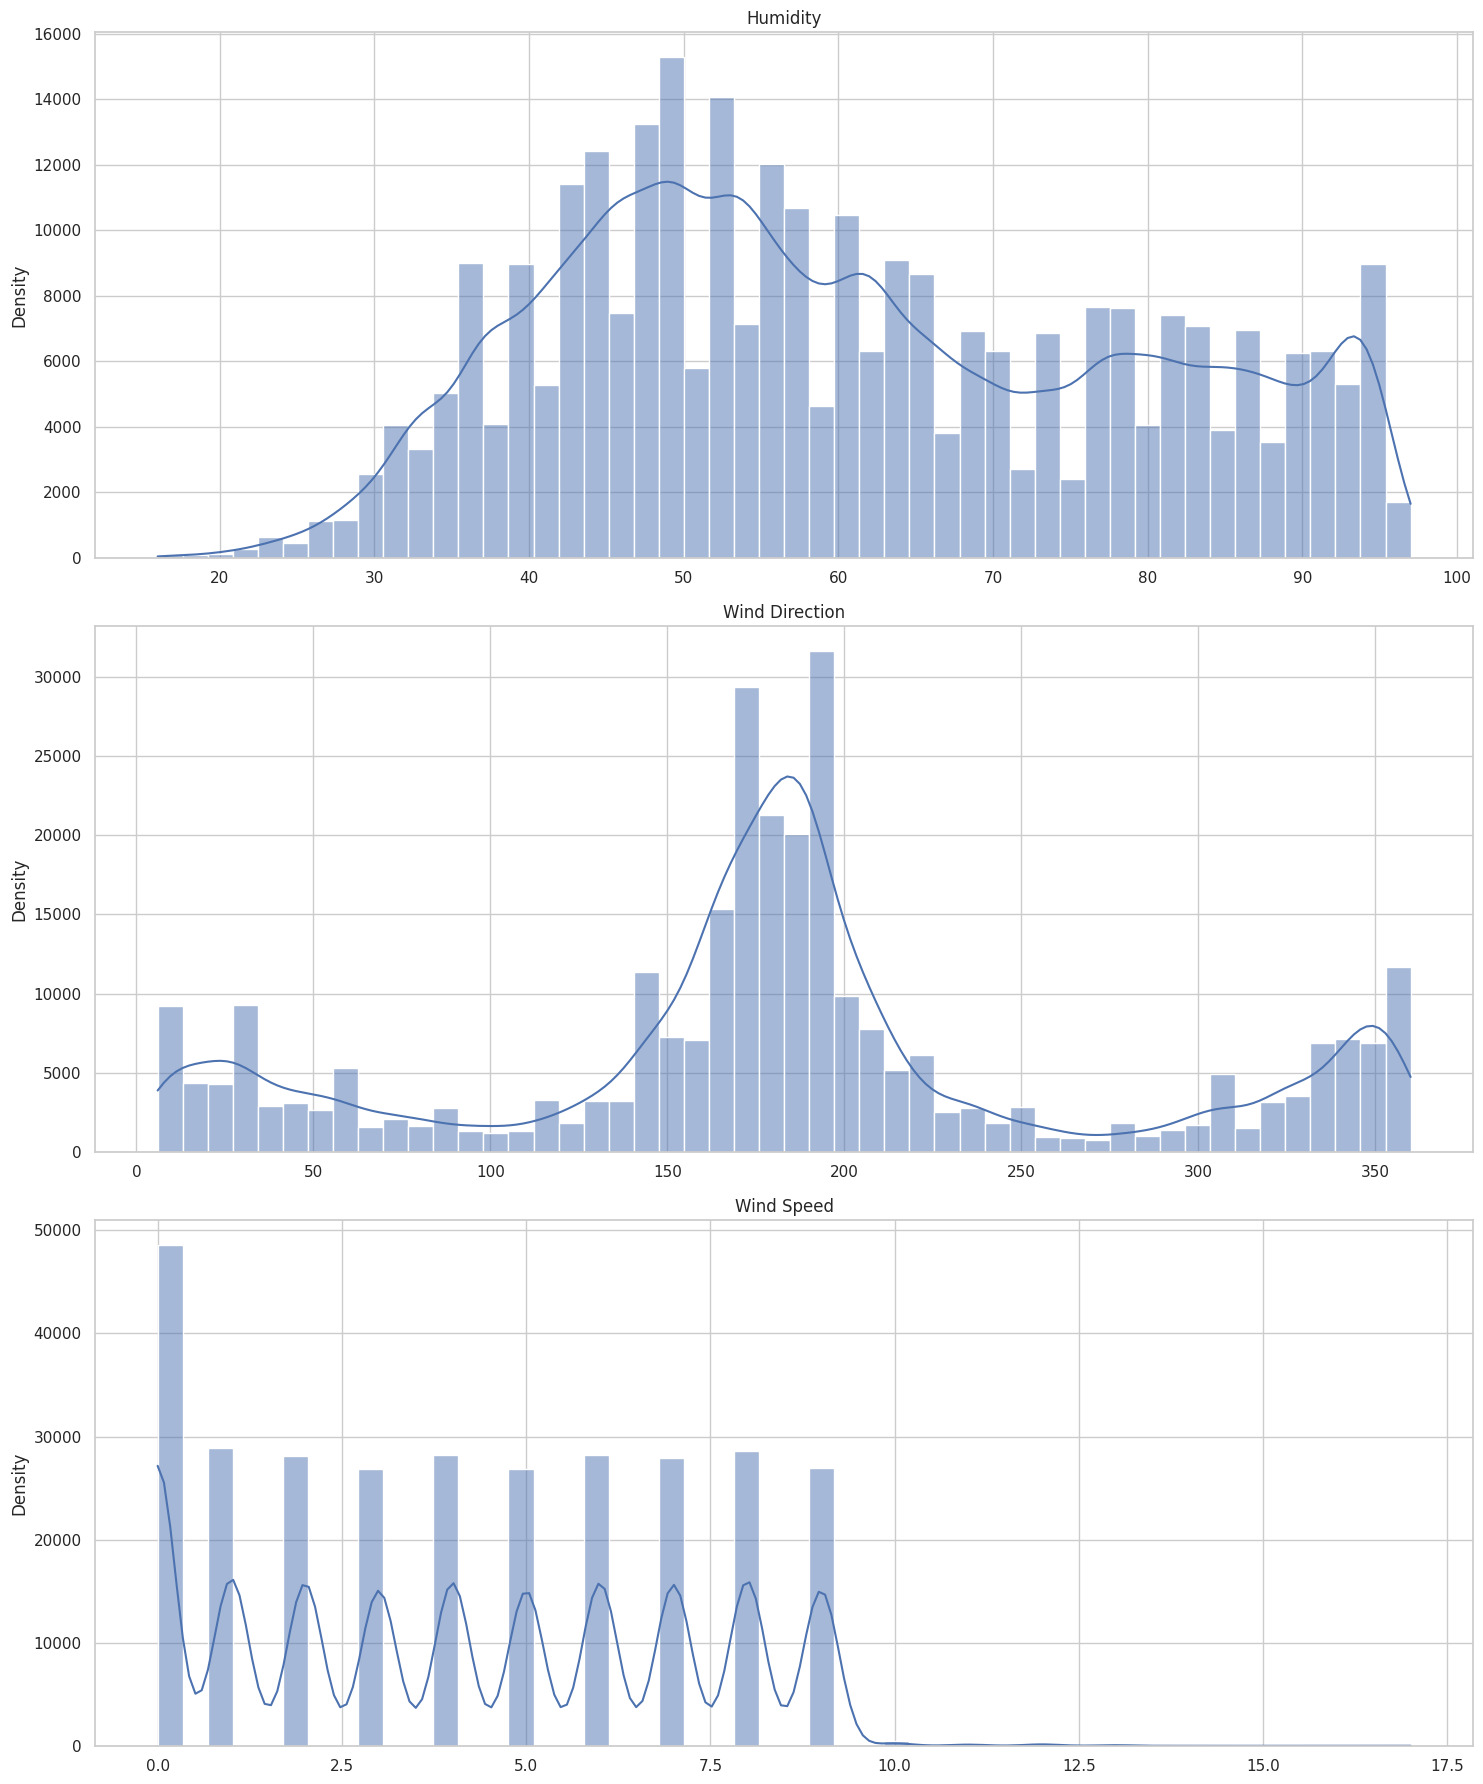

In [ ]:
# Create subplots
fig, axs = plt.subplots(3,1, figsize=(15, 18))
sns.set(style="whitegrid")

# List of variables to plot
variables = ['V15','V16','V17']
titles = ['Humidity',
          'Wind Direction',
          'Wind Speed'
          ]

# Plotting using Seaborn
for ax, var, title in zip(axs.flatten(), variables, titles):
    sns.histplot(data=data, x=var, kde=True, bins=50, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Impute the features
data['V15'] = data['V15'].fillna(data['V15'].mean())
data['V16'] = data['V16'].fillna(data['V16'].mean())
data['V17'] = data['V17'].fillna(data['V17'].mean())

In [ ]:
# Check the Kurtosis and Skewness for continuous distributions:
data['vehicle_speed'].kurt(),data['vehicle_speed'].skew()

(3.3239537865557462, 0.07657978920949342)

In [ ]:
data['prec_vehicle_speed'].kurt(),data['prec_vehicle_speed'].skew()

(3.341926195062494, 0.06326380675356064)

In [ ]:
# Remove ID columns
data.drop(['ID','V7'],axis=1,inplace=True)

In [ ]:
cat_features = data.select_dtypes(include=['object','category'])
num_features = data.select_dtypes(include=['int64', 'float64'])
num_features = num_features.drop('DrivingStyle', axis=1)

In [ ]:
map_impact = {False:0,True:1}
data['risk_of_impact'] = data['risk_of_impact'].map(map_impact)

In [ ]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_features.columns),
    ('cat_pipeline', cat_pipeline, cat_features.columns)
])

In [ ]:
X = data.drop('DrivingStyle',axis=1)
y = data['DrivingStyle']

In [ ]:
X_pca = preprocessor.fit_transform(X)

In [ ]:
X_pca.shape

(303535, 37)

In [ ]:
pca = PCA(n_components=37)
principal_components = pca.fit_transform(X_pca)

In [ ]:
explained_variance = pca.explained_variance_ratio_

In [ ]:
explained_variance

array([2.56586450e-01, 1.25830989e-01, 1.00205798e-01, 8.78229791e-02,
       8.30316379e-02, 5.29434303e-02, 5.22361733e-02, 4.99130332e-02,
       4.40648053e-02, 3.80433507e-02, 2.06185293e-02, 1.93978281e-02,
       1.38288878e-02, 1.09009232e-02, 8.60529297e-03, 7.73979532e-03,
       7.12423008e-03, 5.14983310e-03, 4.12769252e-03, 2.33421279e-03,
       2.14803310e-03, 1.61871165e-03, 1.57587065e-03, 1.17458889e-03,
       1.08688772e-03, 7.03502191e-04, 5.48394123e-04, 4.32661366e-04,
       1.23578235e-04, 6.78460696e-05, 1.12717683e-05, 2.78212199e-06,
       1.72759963e-33, 1.72759963e-33, 1.72759963e-33, 1.72759963e-33,
       1.72759963e-33])

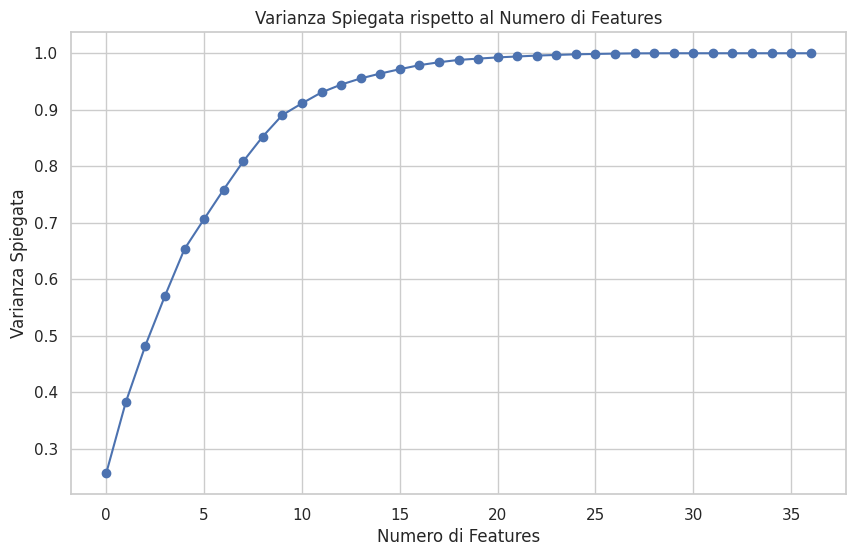

In [ ]:
# Plot della varianza spiegata
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='-', color='b')
plt.xlabel('Numero di Features')
plt.ylabel('Varianza Spiegata')
plt.title('Varianza Spiegata rispetto al Numero di Features')
plt.grid(True)
plt.show()

In [ ]:
# after 15 features the explained variance start to flat
X_processed = preprocessor.fit_transform(X)
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_processed)

# Sprint Report: Data Preprocessing and PCA Analysis

## Objective
Prepare the dataset for modeling by imputing missing values, visualizing key variables, and reducing dimensionality using Principal Component Analysis (PCA).

## Task Summary
1. **Data Imputation**
   - Imputed missing values in 'Air temperature' (`V12`) using the mean value.

2. **Data Visualization**
   - Plotted histograms of humidity (`V15`), wind direction (`V16`), and wind speed (`V17`) to understand their distributions.

3. **Further Data Imputation**
   - Imputed missing values in `V15`, `V16`, and `V17` features with their respective means.

4. **Statistical Analysis**
   - Calculated kurtosis and skewness for continuous distributions:
     - `vehicle_speed`: Kurtosis = [value], Skewness = [value]
     - `prec_vehicle_speed`: Kurtosis = [value], Skewness = [value]

5. **Data Transformation**
   - Removed unnecessary ID columns (`ID`, `V7`) from the dataset.

6. **Data Preparation**
   - Segregated categorical (`cat_features`) and numerical (`num_features`) features.
   - Built pipelines for preprocessing:
     - `num_pipeline`: Imputation with median and scaling using StandardScaler.
     - `cat_pipeline`: Imputation with most frequent value and encoding using OneHotEncoder.

7. **Principal Component Analysis (PCA)**
   - Applied PCA to reduce dimensionality:
     - Transformed the dataset using `preprocessor`.
     - Configured PCA to retain 15 principal components.
     - Analyzed explained variance to understand feature importance.

## Impediments
- No major impediments encountered during this sprint.

## Next Sprint Goals
1. **Model Building**
   - Use preprocessed data for training machine learning models.
   - Evaluate model performance using appropriate metrics.
   
2. **Optimization and Validation**
   - Fine-tune model parameters and validate against test datasets.

## Conclusion
The sprint focused on data preprocessing, visualization, and dimensionality reduction using PCA. The dataset is now ready for model training and validation in the subsequent sprint, aiming to achieve accurate predictions of driving styles based on the processed features.

In [ ]:
# train,test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

In [ ]:
LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)

In [ ]:
# check the unique values
print(np.unique(y_train))
print(np.unique(y_test))

[0 1 2]
[0 1 2]


In [ ]:
Logreg = LogisticRegression()
Logreg.fit(X_train,y_train)
y_pred = Logreg.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.49      0.25      0.33     14172
           1       0.68      0.73      0.71     48939
           2       0.54      0.61      0.57     27950

    accuracy                           0.62     91061
   macro avg       0.57      0.53      0.54     91061
weighted avg       0.61      0.62      0.61     91061



In [ ]:
RFC = RandomForestClassifier()
RFC.fit(X_train,y_train)
y_pred = RFC.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.51      0.60     14172
           1       0.82      0.85      0.83     48939
           2       0.73      0.78      0.76     27950

    accuracy                           0.78     91061
   macro avg       0.76      0.72      0.73     91061
weighted avg       0.78      0.78      0.77     91061



In [ ]:
XGB = xgb.XGBClassifier()
XGB.fit(X_train,y_train)
y_pred = XGB.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.59      0.38      0.46     14172
           1       0.77      0.78      0.77     48939
           2       0.62      0.72      0.67     27950

    accuracy                           0.70     91061
   macro avg       0.66      0.62      0.63     91061
weighted avg       0.69      0.70      0.69     91061



In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping

In [ ]:
# optimize the dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.shuffle(buffer_size=len(X_train)).batch(32).prefetch(tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
FFW = Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])

FFW.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5,
                           restore_best_weights=True,
                           verbose=1,
                           mode='max')

In [ ]:
# Example of correct usage assuming train_data and test_data are tuples
history = FFW.fit(train_data,validation_data=test_data,epochs=100,
                  callbacks=[early_stop])

Epoch 1/100
6640/6640 [==============================] - 32s 5ms/step - loss: 0.7248 - accuracy: 0.6529 - val_loss: 0.7007 - val_accuracy: 0.6693
Epoch 2/100
6640/6640 [==============================] - 32s 5ms/step - loss: 0.6904 - accuracy: 0.6753 - val_loss: 0.6779 - val_accuracy: 0.6794
Epoch 3/100
6640/6640 [==============================] - 31s 5ms/step - loss: 0.6625 - accuracy: 0.6897 - val_loss: 0.6498 - val_accuracy: 0.6969
Epoch 4/100
6640/6640 [==============================] - 32s 5ms/step - loss: 0.6305 - accuracy: 0.7075 - val_loss: 0.6190 - val_accuracy: 0.7143
Epoch 5/100
6640/6640 [==============================] - 32s 5ms/step - loss: 0.5991 - accuracy: 0.7257 - val_loss: 0.5995 - val_accuracy: 0.7201
Epoch 6/100
6640/6640 [==============================] - 31s 5ms/step - loss: 0.5680 - accuracy: 0.7419 - val_loss: 0.5686 - val_accuracy: 0.7425
Epoch 7/100
6640/6640 [==============================] - 31s 5ms/step - loss: 0.5394 - accuracy: 0.7576 - val_loss: 0.5383 -

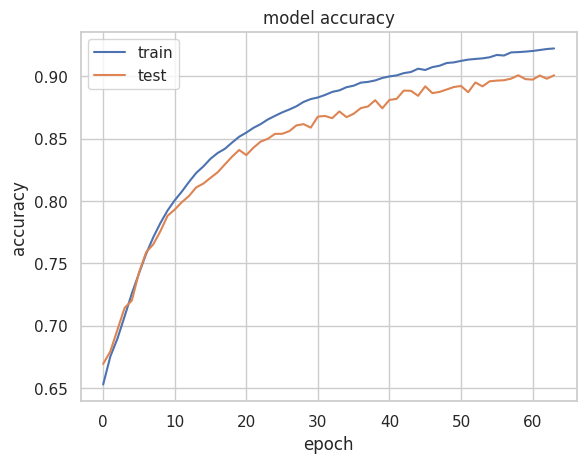

In [ ]:
# plot the curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
y_pred = FFW.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test,y_pred))

2846/2846 [==============================] - 6s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     14172
           1       0.93      0.93      0.93     48939
           2       0.89      0.90      0.90     27950

    accuracy                           0.90     91061
   macro avg       0.88      0.88      0.88     91061
weighted avg       0.90      0.90      0.90     91061

